## Two-dimensional advection equation

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = 0
\end{equation}

The independen variables (i.e, $x$, $y$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi(x,y,t)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [1]:
# imports
import numpy as np 
import matplotlib.pyplot as plt 
import nangs
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.06', '1.11.0+cpu')

In [2]:
from nangs import PDE

U, V = -0.5, 1

class Adv2d(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        return {'pde': dpdt + U*dpdx + V*dpdy}
    
pde = Adv2d(inputs=('x', 'y', 't'), outputs='p')

In [3]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [0., 1.], 
    'y': [0., 1.],
    't': [0., 1.], 
}, device=device, n_samples=1000)

pde.set_sampler(sampler)

C:\Users\Bell\AppData\Local\Temp\ipykernel_5764\4237577088.py:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


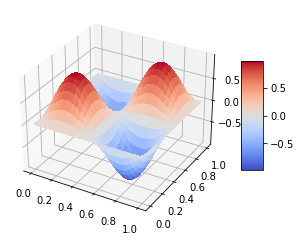

In [4]:
# initial condition (t = 0)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)
t0 = np.array([0])
_x, _y = np.meshgrid(x, y)
p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(_x, _y, p0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [5]:
from nangs import Dirichlet, Periodic

n_samples = 1000
initial_condition = Dirichlet(
    RandomSampler({'x': [0., 1.], 'y': [0., 1.], 't': 0.}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : torch.sin(2.*np.pi*inputs['x'])*torch.sin(2.*np.pi*inputs['y'])},
    name="initial"
)

pde.add_boco(initial_condition)

periodic_x = Periodic(
    RandomSampler({'t': [0., 1.], 'y': [0., 1.]}, device=device, n_samples=n_samples), 
    RandomSampler({'x': 0.}, device=device, n_samples=n_samples), 
    RandomSampler({'x': 1.}, device=device, n_samples=n_samples), 
    name="periodic-x"
)

periodic_y = Periodic(
    RandomSampler({'t': [0., 1.], 'x': [0., 1.]}, device=device, n_samples=n_samples), 
    RandomSampler({'y': 0.}, device=device, n_samples=n_samples), 
    RandomSampler({'y': 1.}, device=device, n_samples=n_samples), 
    name="periodic-y"
)

pde.add_boco(periodic_x)
pde.add_boco(periodic_y)

In [6]:
# solve

from nangs import MLP

LR = 1e-2
N_STEPS = 5000
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'pde': 1e-05, 'initial': 1e-05, 'periodic-x': 0.0, 'periodic-y': 1e-05}: 100%|████| 5000/5000 [06:03<00:00, 13.75it/s]

Wall time: 6min 3s


<AxesSubplot:>

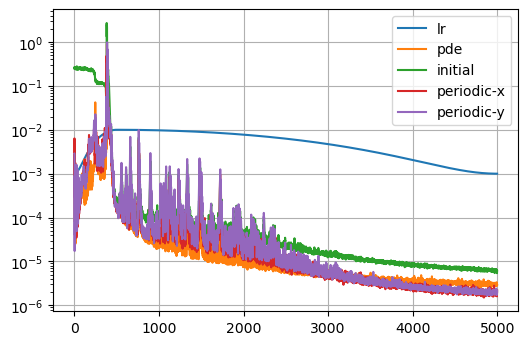

In [7]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

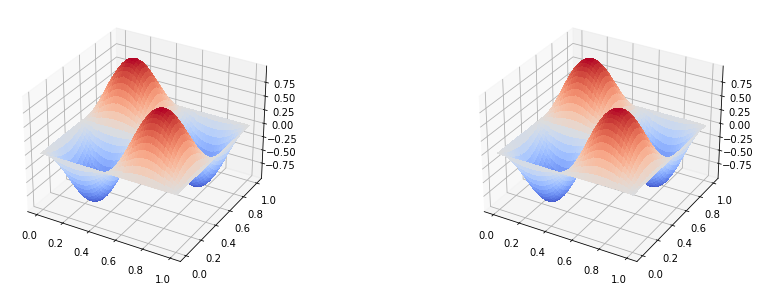

L2 error:  0.38811386912432644


In [8]:
t = 1.
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

_x, _y = np.meshgrid(x, y)
p0 = np.sin(2*np.pi*(_x - U*t))*np.sin(2*np.pi*(_y - V*t))

p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

grid = np.stack(np.meshgrid(x, y, t), -1).reshape(-1, 3)
X = torch.from_numpy(grid).float().to(device)
p = pde.eval(X)
p = p.cpu().numpy()

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(_x, _y, p0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.plot_surface(_x, _y, p.reshape((len(_y),len(_x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()
print("L2 error: ", np.sqrt(sum((p0.ravel()-p.ravel())**2)))